In [48]:
import numpy as np

import tensorflow as tf

from tensorflow.keras import (
    datasets,
    layers,
    models,
    metrics,
    optimizers,
    callbacks,
    losses
)

import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
(x_train, y_train),(x_test,y_test) = datasets.fashion_mnist.load_data()

In [38]:
def preprocess(imgs):
    # make sure that the pixel values are scaled between 0 and 1
    imgs = imgs.astype('float32') / 255.0
    # change image size to 32x32 for easier manipulation of the tensor shape as it passes through the net.
    imgs = np.pad(imgs,((0,0),(2,2),(2,2)), constant_values=0.0)
    imgs = np.expand_dims(imgs,-1)

    return imgs

def show_random_predictions(original_images, z, decoder, n=5):
    """
    Display random original and generated images using a latent space vector `z` 
    and a decoder to reconstruct the generated images.
    
    Parameters:
    original_images -- array of original images
    z -- latent space vectors
    decoder -- decoder model that generates images from `z`
    n -- number of images to display (default is 5)
    """
    
    random_indices = np.random.choice(original_images.shape[0], n, replace=False)

   plt.figure(figsize=(10, 4))

    for i, idx in enumerate(random_indices):
        # Original images
        plt.subplot(2, n, i + 1)
        plt.imshow(original_images[idx].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Generated images by decoder
        z_sample = np.expand_dims(z[idx], axis=0)  # делаем батч из одного примера
        generated_image = decoder.predict(z_sample)

        # show generated image
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(generated_image.squeeze(), cmap='gray')
        plt.title("Generated")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def show_random_predictions2(sample, generated_images, reconstructed_classes=0, n=5):
    n = min(n, sample.shape[0])
    random_indices = np.random.choice(sample.shape[0], n, replace=False)

    plt.figure(figsize=(18, 6))

    for i, idx in enumerate(random_indices):       
        plt.subplot(2, n, i + 1)
        plt.imshow(generated_images[idx].squeeze(), cmap='gray')
        coord = f"({sample[idx, 0]:.2f}, {sample[idx, 1]:.2f})"
        #category = f"Class: {reconstructed_classes[idx]}"
        #plt.title(f"{coord}\n{category}")
        plt.title(f"{coord}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

**FAQ**

    -Q: What is Embeding?
    -A: The embeding is a compression of the original image into a lower-dimensional latent space

In [4]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

# BUILD MODEL

## ENCODER

The VAE encoder will take each input image and only needs to map that each input to:
1. z_mean: a mean vector and
2. z_log_var: a variance vector

and does not need to worry about covariance between these 2 vectors dimensions as variational autoencoders assume that there is no correlation between dimensions in the latent space.
Together these two vectors define a multivariate normal distribution in the latent space.

To sample a point z from the distribution defined by values above we can use following equation:
``` python
z = z_mean + z_sigma * epsilon
```
where
``` python
z_sigma = exp(z_log_var * 0.5)
epsilon ~ N(0,I)
```
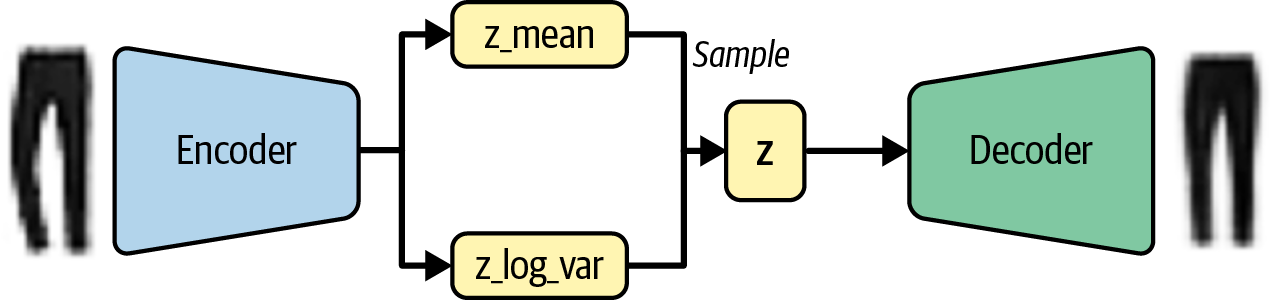


In an autoencoder, each image is mapped directly to one point in the latent space. In a variational autoencoder, each image is instead mapped to a multivariate normal distribution around a point in the latent space
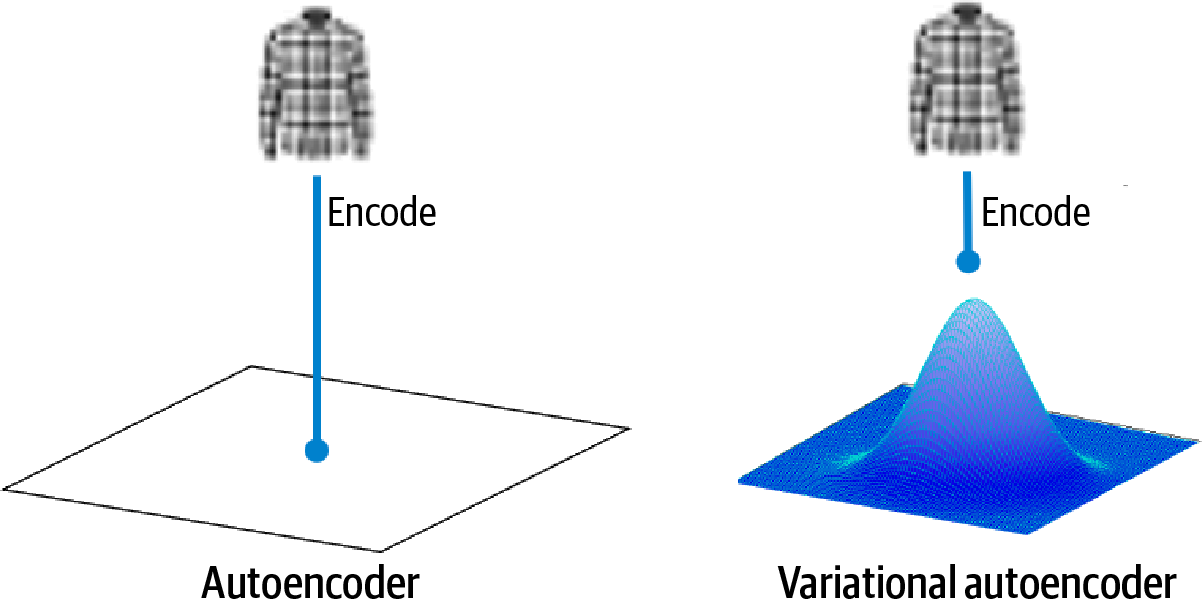

### SAMPLING LAYER

A Sampling layer will allow us to sample from the distribution defined by z_mean and z_log_var

In [5]:

class Sampling(layers.Layer):
    '''
    A Sampling layer will handle the sampling of z from a normal distribution with parameters defined by z_mean and z_log_var.
    This is useful as we want to apply a transformation to a tensor that isn’t already included in an abstract realisation.
    '''    
    
    def call(self, inputs):
        '''
        Call method,which describes how a tensor is transformed by the layer.
        '''
        z_mean, z_log_var = inputs
        # Get number of samples per one call
        batch = tf.shape(z_mean)[0]
        # Get latent space dimensionality
        dim = tf.shape(z_mean)[1]
        # Generate random noise from the variance N(0,1), it will the same dims as a latent z_mean
        epsilon = K.random_normal(shape=(batch, dim))

        # Calculate new selection
        # z = μ + σ ⋅ ϵ
        # μ=z_mean
        # σ=exp⁡(0.5⋅z_log_var)
        # ϵ - taking the exponential ensures that the variance(выборка) is positive
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
# Input is a b&w picture size of 32x32
# Output is a Tensor size of 32x32x1
encoder_input = layers.Input(
    shape=(32,32,1),
    name='encoder_input'    
)

# Input is a tensor from an encoder_input layer
# Output is the Tensor 16x16x32
x = layers.Conv2D(
    32,
    (3,3),
    strides=2,
    activation='relu',
    padding='same'
)(encoder_input)

# Input is the Tensor from layer above
# Output is the Tensor 8x8x64
x = layers.Conv2D(
    64,
    (3,3),
    strides=2,
    activation='relu',
    padding='same'
)(x)

#Input is the Tensor from layer above
#Output is the Tensor 4x4x128
x = layers.Conv2D(
    128,
    (3,3),
    strides=2,
    activation='relu',
    padding='same'
)(x)

# this var will save Tensor shape befoure flattening it 4x4x128
shape_befoure_flattening = K.int_shape(x)[1:]

# Outpuut is 4x4x128 = 2048
x = layers.Flatten()(x)

# VAE Addition
# input x=[z1​,z2​,…,z2048​]
# output 2-rank tensor. example if  batch_size=4, then result could be:
#         | 1.23 −0.84 |
#         |0.56 2.14|
#  z_mean=|−1.12 0.33|
#         |1.67−0.75]

z_mean = layers.Dense(2, name='z_mean')(x)
z_log_var = layers.Dense(2, name='z_log_var')(x)

# The Sampling layer samples a point z in the latent space from the normal distribution defined by the parameters z_mean and z_log_var.
z = Sampling()([z_mean, z_log_var])

2024-09-23 21:58:21.922297: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-23 21:58:21.926895: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-23 21:58:21.926924: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-23 21:58:21.929922: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-23 21:58:21.929954: I external/local_xla/xla/stream_executor

In [7]:
# Instead of connecting the Flatten layer directly to the 2D latent space, we connect it to layers z_mean and z_log_var.
# Encoder takes an image as an input and outputs z_mean, z_log_var, and a sampled point z from the normal distribution defined by these parameters.
encoder = models.Model(
    encoder_input, 
    [
        z_mean, 
        z_log_var,
        z
    ]
)

In [8]:
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

## DECODER

**CONVOLUTIONAL TRANSPOSE LAYERS**

For more theory ub this subject open my autoencoders notebook

In [9]:
# Decoder get input vector from the encoder output
# The vector shape is (2,)
decoder_input = layers.Input(
    shape=(2,),
    name='decoder_input'
)

#  Turn vector of 2 elemnts into a flat vector of 2048 elements
x= layers.Dense(
    np.prod(shape_befoure_flattening)
)(decoder_input)

# Reshape vector into a Tensor
# # Restore Vector from the latent space into the 3d Tensor shape of 4x4x128
x = layers.Reshape(
    shape_befoure_flattening
)(x)

# Output Tenzor shape 8x8x128
x = layers.Conv2DTranspose(
    128,
    (3,3),
    strides=2,
    activation='relu',
    padding='same'
)(x)

# Output Tensor 16x16x64
x = layers.Conv2DTranspose(
    64,
    (3,3),
    strides=2,
    padding='same'
)(x)

# Output Tensor 32z32x32
x = layers.Conv2DTranspose(
    32,
    (3,3),
    strides=2,
    activation='relu',
    padding='same'
)(x)

# Output Tensor shape of 32x32x1(Generating b&w imgae shape 32x32) with sigmoid normalization
decoder_output = layers.Conv2D(
    1,
    (3,3),
    strides=1,
    activation='sigmoid',
    padding='same',
    name='decoder_output'
)(x)

In [10]:
decoder = models.Model(decoder_input,decoder_output)

In [11]:
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

## VAE

Loss function
In a VAE, we want to measure how much our normal distribution with parameters z_mean and z_log_var differs from a standard normal distribution.

$$
D_{KL} \left[ N(\mu, \sigma) \parallel N(0, 1) \right] = - \frac{1}{2} \sum \left( 1 + \log(\sigma^2) - \mu^2 - \sigma^2 \right)
$$

In python this formula looks like:
``` python
kl_loss = -0.5 * sum(1 + z_log_var - z_mean ^ 2 - exp(z_log_var))
```

In [27]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(500 * losses.binary_crossentropy(data, reconstruction, axis=(1,2,3)))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean)-tf.exp(z_log_var)), axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self,data):
        if isinstance(data, tuple):
            data=data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(500 * losses.binary_crossentropy(data, reconstruction, axis=(1,2,3)))
        kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5*(1+z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
        total_loss = reconstruction_loss +kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss":kl_loss,
        }

In [28]:
vae = VAE(encoder,decoder)

# COMPILE MODEL

**CHOOSING THE LOSS FUNCTION**

Optimizing for RMSE means that your generated output will be symmetrically distributed around the average pixel values (because an overestimation is penalized equivalently to an underestimation). On the other hand, binary cross-entropy loss is asymmetrical—it penalizes errors toward the extremes more heavily than errors toward the center. For example, if the true pixel value is high (say 0.7), then generating a pixel with value 0.8 is penalized more heavily than generating a pixel with value 0.6. If the true pixel value is low (say 0.3), then generating a pixel with value 0.2 is penalized more heavily than generating a pixel with value 0.4. This has the effect of binary cross-entropy loss producing slightly blurrier images than RMSE loss (as it tends to push predictions toward 0.5), but sometimes this is desirable as RMSE can lead to obviously pixelized edges.

In [29]:
optimizer = optimizers.Adam(learning_rate=5e-4)
vae.compile(optimizer=optimizer, run_eagerly=True)

# TRAIN MODEL

In [30]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='./checkpoint.keras',
    save_weights_only=False,
    save_freq='epoch',
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=0
)
tensorboard_callback = callbacks.TensorBoard(log_dir='./logs')

In [31]:
vae.fit(x_train,
       epochs=5,
       batch_size=100,
       shuffle=True,
       validation_data=(x_test, x_test),
       callbacks=[model_checkpoint_callback,tensorboard_callback])

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 52s 85ms/step - kl_loss: 3.5389 - reconstruction_loss: 195.6354 - total_loss: 199.1743 - val_kl_loss: 4.9836 - val_loss: 142.0167 - val_reconstruction_loss: 137.0331
Epoch 2/5
  1/600 ━━━━━━━━━━━━━━━━━━━━ 1:09 116ms/step - kl_loss: 4.9336 - reconstruction_loss: 133.8502 - total_loss: 138.7838

/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 53s 89ms/step - kl_loss: 5.0058 - reconstruction_loss: 131.8680 - total_loss: 136.8738 - val_kl_loss: 5.0025 - val_loss: 139.2973 - val_reconstruction_loss: 134.2948
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 72s 121ms/step - kl_loss: 5.0245 - reconstruction_loss: 129.8978 - total_loss: 134.9223 - val_kl_loss: 4.9645 - val_loss: 136.5335 - val_reconstruction_loss: 131.5690
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 60s 100ms/step - kl_loss: 5.0681 - reconstruction_loss: 128.8974 - total_loss: 133.9656 - val_kl_loss: 5.3023 - val_loss: 136.2046 - val_reconstruction_loss: 130.9023
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 62s 104ms/step - kl_loss: 5.1112 - reconstruction_loss: 127.9434 - total_loss: 133.0547 - val_kl_loss: 5.1875 - val_loss: 135.5177 - val_reconstruction_loss: 130.3302


# RECONSTRUCT IMAGES

In [35]:
n_to_predict = 5000

example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

z_mean, z_var, z = encoder.predict(example_images)

I0000 00:00:1727097793.301373   15849 service.cc:145] XLA service 0x7f30d8006660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727097793.301608   15849 service.cc:153]   StreamExecutor device (0): NVIDIA T1200 Laptop GPU, Compute Capability 7.5
2024-09-24 00:23:13.324058: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


120/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

I0000 00:00:1727097794.179615   15849 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


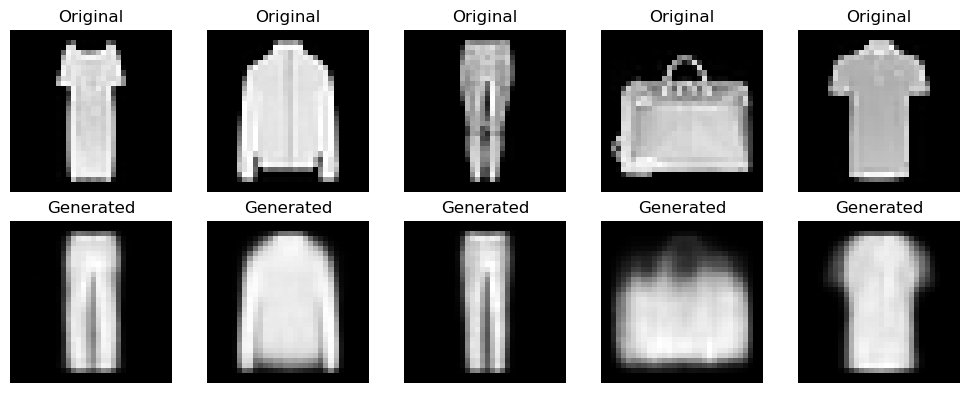

In [40]:
show_random_predictions(example_images, z,decoder,n=5)

**SUMMARY**

Notice how the reconstruction isn’t perfect—there are still some details of the original images that aren’t captured by the decoding process, such as logos. This is because by reducing each image to just two numbers, we naturally lose some information.

# LATENT SPACE

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


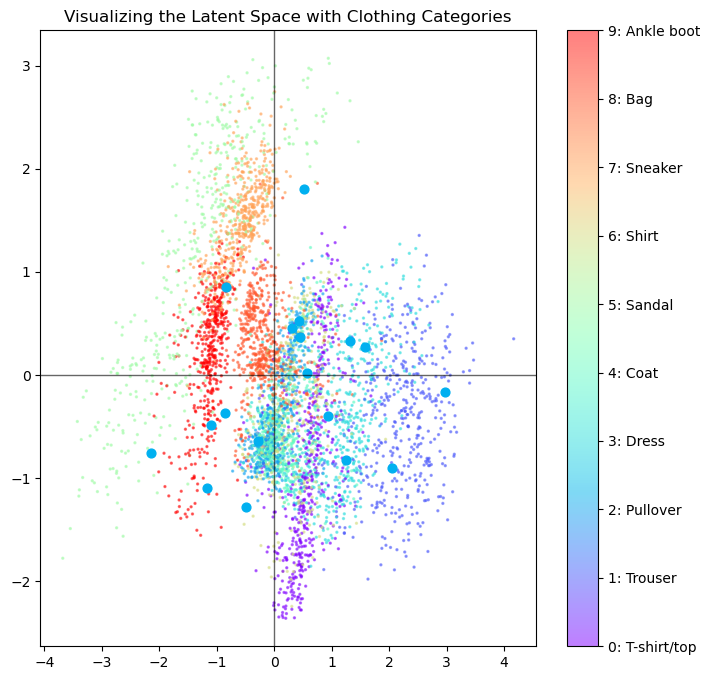

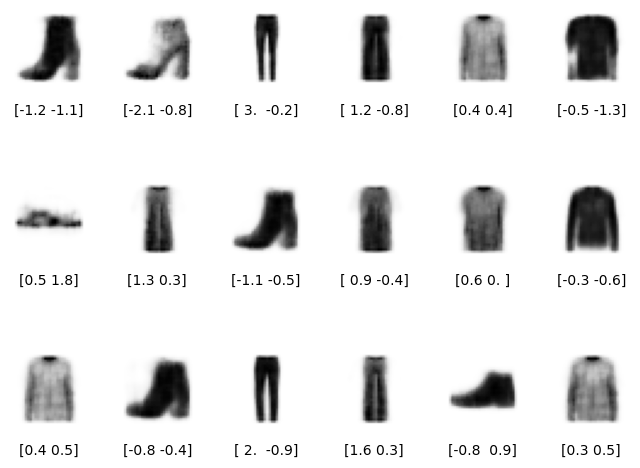

In [55]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

# Use the decoder to reconstruct images from the sampled latent points
reconstructions = decoder.predict(z_sample)

# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

# Presume z is the original latent embeddings of your dataset and example_labels are the corresponding labels
# Example class labels for clothing items, same as in your initial description
class_labels = {
    0: "0: T-shirt/top",
    1: "1: Trouser",
    2: "2: Pullover",
    3: "3: Dress",
    4: "4: Coat",
    5: "5: Sandal",
    6: "6: Shirt",
    7: "7: Sneaker",
    8: "8: Bag",
    9: "9: Ankle boot",
}

# Convert label ID's into text
text_labels = [class_labels[label] for label in example_labels]

# Plotting latent space with the original embeddings and newly sampled points
figsize = 8
plt.figure(figsize=(figsize, figsize))

# Scatter plot for original embeddings with color based on clothing category
scatter = plt.scatter(
    z[:, 0],  # First dimension of embeddings
    z[:, 1],  # Second dimension of embeddings
    c=example_labels,  # Color by clothing categories
    cmap="rainbow",
    alpha=0.5,
    s=2
)

# Add a colorbar with clothing categories
cbar = plt.colorbar(scatter, ticks=np.arange(10))
cbar.set_ticklabels([class_labels[i] for i in range(10)])

# Plot the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)

plt.axhline(0, color='black', linewidth=1, alpha=0.6)
plt.axvline(0, color='black', linewidth=1, alpha=0.6)

plt.title("Visualizing the Latent Space with Clothing Categories")
plt.show()

# Add underneath a grid of the decoded images from the sampled points
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")


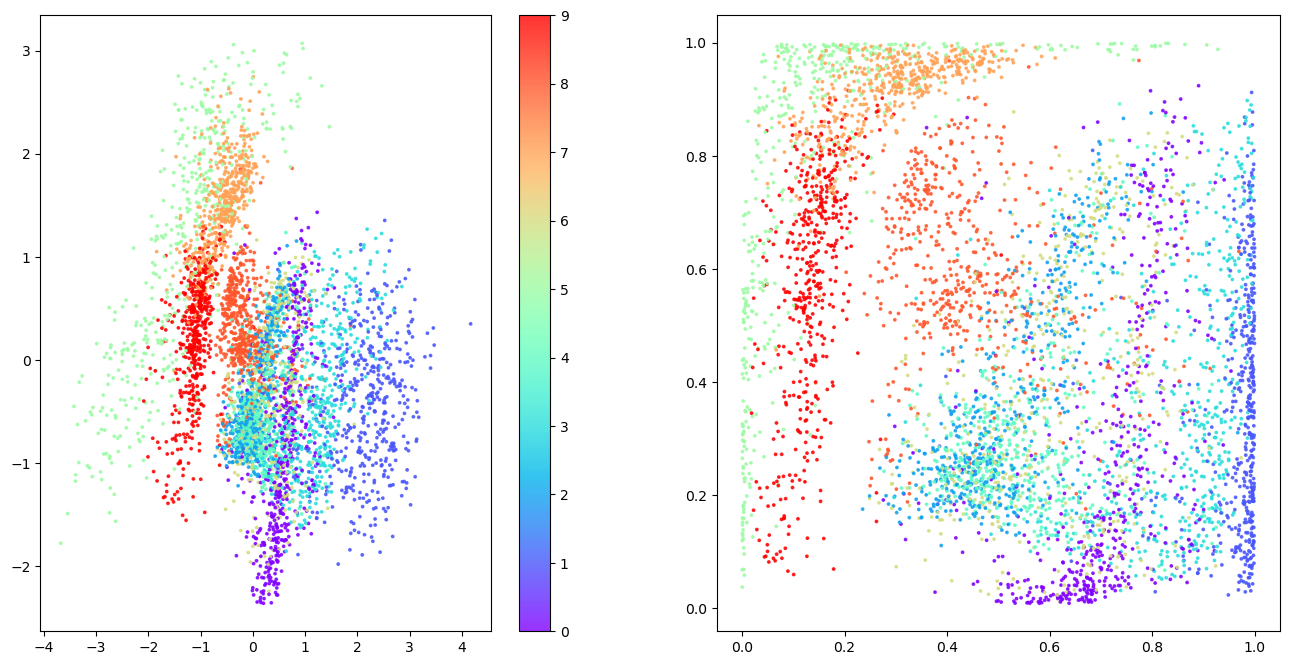

In [53]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

**Summary**

The righthand plot shows the space transformed into p-values—we can see that each color is approximately equally represented.

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  


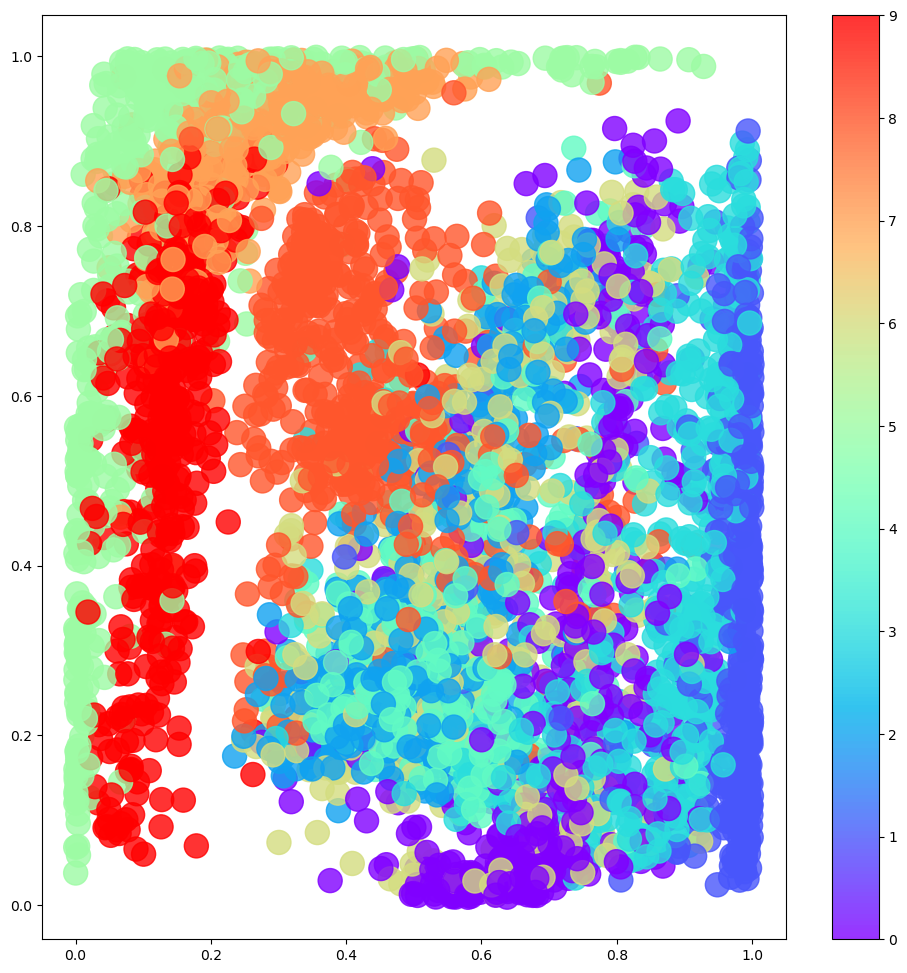

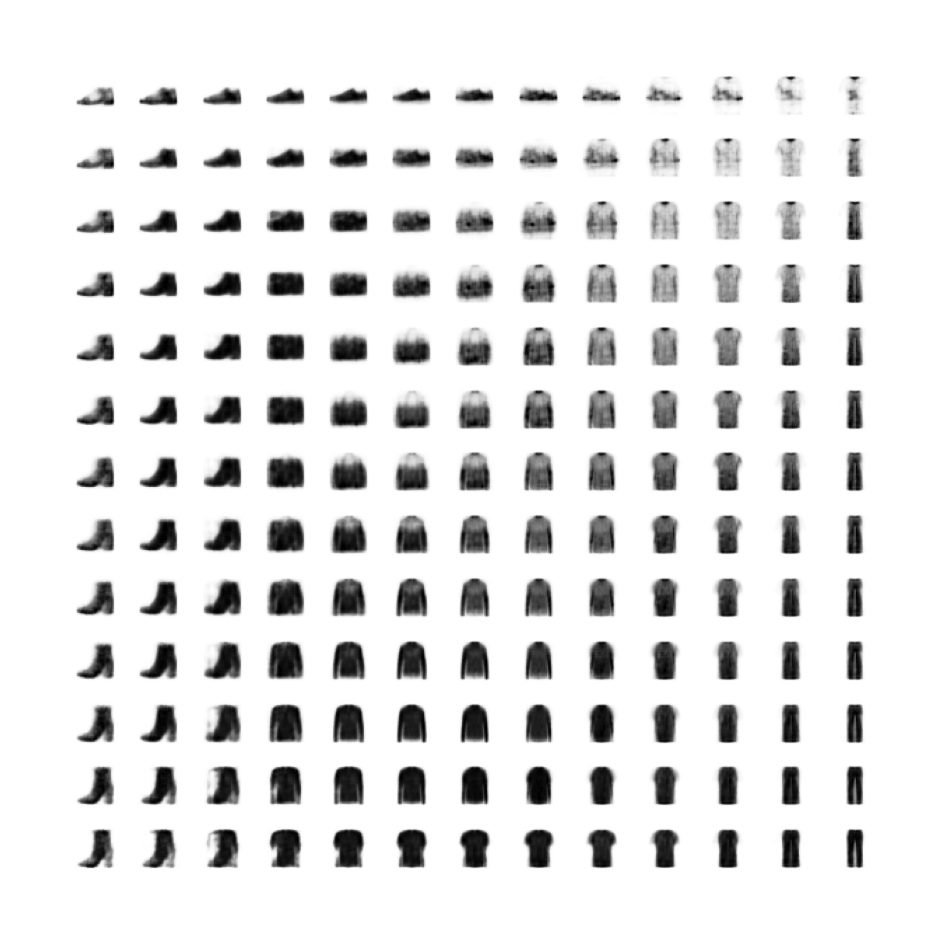

In [54]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

**References**

1. [Generative Deep Learning, 2nd Edition](https://www.oreilly.com/library/view/generative-deep-learning/9781098134174/): David Foster's book from which has become an inspiration of this notebook.
2. [David Foster](https://github.com/davidADSP): GitHub page
3. [David Foster (Keynote) - Generative Deep Learning -Key To Unlocking Artificial General Intelligence?](https://www.youtube.com/watch?v=rHLf78CmNmQ): David's video session at Youtube regarding some key concepts has written in his book
4. [Animated AI](https://www.youtube.com/@animatedai): Youtube channel with amazing visualizations of how exactly convolution is work.
5. [Make Your Own Neural Network](https://makeyourownneuralnetwork.blogspot.com/2020/02/calculating-output-size-of-convolutions.html): Article explains convolution and T-convolution